# Supervised Learning with Kernel Methods

Here we use a variational classifier to learn a nonlinear boundary using kernel methods.

The variational circuit architecture is specified by [Farhi and Neven (2018)](https://arxiv.org/abs/1802.06002). 
The kernel map is specified by [Havlicek et al (2018)](https://arxiv.org/abs/1804.11326)

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

from scipy.stats import unitary_group
import matplotlib.pyplot as plt

In [2]:
dev = qml.device('default.qubit', wires=2)

We begin with a subgate in our kernel map.

In [3]:
def U_phi(x):
    #print(x, np.shape(x))
    # x3 := (pi - x1)(pi - x2)
    x_0, x_1, x_2 = x[0], x[1], x[2]
    #print(x_0, x_1, x_2)
        
    qml.RZ( x_0 , wires=0)
    qml.RZ( x_1 , wires=1)
    
    qml.CNOT(wires=[0,1])
    qml.RZ(x_2,wires=1)
    qml.CNOT(wires=[0,1])

Our kernel map is specified by U_phi interlaced twice with hadamards on all qubits.

In [4]:
def featuremap(x):
    for i in range(2):
        qml.Hadamard(wires=0)
        qml.Hadamard(wires=1)
        U_phi(x)

OK. We are ready to define a layer of our variational circuit. This is the component of the circuit that is tunable by learned weights.

In [5]:
def layer(W): # 6 weights are specified at each layer
    
    # euler angles
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)

    qml.CNOT(wires=[0, 1])

We can fully specify our variational circuit. This circuit

1. maps the classical data using the above feature map
2. applies a specified number of the above variational layers which are parameterized by tunable weights
3. Measures the expectation of Z on both qubits so as to compute expected parity

Hence, we define two circuits for each expected Z on a qubit.

In [6]:
@qml.qnode(dev)
def circuit1(weights, x):

    featuremap(x)

    for W in weights:
        layer(W)

    return qml.expval.PauliZ(wires=0)

@qml.qnode(dev)
def circuit2(weights, x):

    featuremap(x)

    for W in weights:
        layer(W)

    return qml.expval.PauliZ(wires=1)

One more modification: we add a bias and specify multiplying the expectations of the two circuits.

In [7]:
def variational_classifier(var, x): # x is a keyword argument -> fixed (not trained)
    weights = var[0]
    bias = var[1]

    return circuit1(weights, x) * circuit2(weights, x) + bias

Here, we use L2 loss

In [8]:
def square_loss(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)

    return loss

In [9]:
def accuracy(labels, predictions):
    #print(labels, predictions)
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [10]:
def cost(var, X, Y):

    predictions = [variational_classifier(var, x) for x in X]
    #if (len(Y) == num_data):
    #    print("[(pred, label), ...]: ", list(zip(predictions, Y)))
    return square_loss(Y, predictions) 

To generate a random element of SU(4), we generate a random element of U(4) and divide appropriately to scale the determinant to +1.

It is essential to note that the same fixed element of SU(4) is used to generate labels for the initial dataset. In this sense, one sees that we primarily require the tunable layers of the variational circuit to approximate this matrix in order to well-classify samples.

In [11]:
random_U = unitary_group.rvs(4)
random_U = random_U / (np.linalg.det(random_U) ** (1/4)) # so that det = 1


print("random unitary: ", random_U)
print("det: ", np.linalg.det(random_U))

random unitary:  [[-0.407647  -0.45058874j -0.08127845-0.59183803j -0.02831122-0.32707035j
   0.1789053 +0.36623984j]
 [ 0.35961036-0.14874338j  0.10586942+0.41134434j -0.47860656-0.3450007 j
   0.45274678+0.33922548j]
 [-0.6698028 -0.13303111j  0.30145751+0.57553657j  0.02361796-0.20258723j
  -0.26193097+0.03661596j]
 [-0.11195661+0.02195794j  0.02329741+0.20011825j  0.53183724+0.46870406j
   0.49018537+0.45119557j]]
det:  (1+2.220446049250313e-16j)


We label classical data by

1. applying the above feature map
2. applying the fixed random unitary
3. returning expected parity

If the absolute value of the expected parity is above a predetermined threshold, then we can use this point and label by sign. If not, then we continue generating more random samples.

In [12]:
@qml.qnode(dev)
def data_label_1(x):
    #print(u)
    #print("label the following:", x)
    featuremap(x)
    qml.QubitUnitary(random_U, wires=[0,1])
    
    return qml.expval.PauliZ(wires=0)

@qml.qnode(dev)
def data_label_2(x):
    #print("label the following:", x)
    featuremap(x)
    qml.QubitUnitary(random_U, wires=[0,1])
    
    return qml.expval.PauliZ(wires=1)

In [13]:
def gen_data(thresh):
    #thresh = 0.3

    X = np.array([])
    Y = np.array([])
    ctr = 0 # num valid data pts
    maxval = 0.0
    minval = 0.0

    np.random.seed(0)

    while ctr < 40:
        x = np.random.rand(2) * 2 * np.pi
        x = np.append(x, (np.pi - x[0]) * (np.pi - x[1]))
        y_1 = data_label_1(x)
        y_2 = data_label_2(x)
        #print(y_1, y_2, y_1 * y_2)
        if (np.abs(y_1 * y_2) > maxval):
            maxval = y_1 * y_2
            #print("new max separation: ", maxval)
        elif (y_1 * y_2 < minval):
            minval = y_1 * y_2
            #print("new min separation: ", minval)

        if y_1 * y_2 > thresh:
            Y = np.append(Y, +1)
            X = np.append(X, x)
            ctr += 1
            #print("+1")
        elif y_1 * y_2 < -1 * thresh:
            Y = np.append(Y, -1)
            X = np.append(X, x)
            ctr += 1
            #print("-1")
            
    X = X.reshape(-1, 3)
    print("Data: ", list(zip(X, Y)))
    return X, Y

We can divide our training and test data randomly from the generated dataset. We specify that half is used for each. 

In [14]:
def divide_train_test(X, Y):
    global num_data
    num_data = len(Y)
    global num_train
    num_train = int(0.5 * num_data)

    print("size data, size train: ", num_data, num_train)

    index = np.random.permutation(range(num_data))
    X_train = X[index[:num_train]]
    Y_train = Y[index[:num_train]]

    X_test = X[index[num_train:]]
    Y_test = Y[index[num_train:]]
    
    return X_train, Y_train, X_test, Y_test

In [15]:
num_qubits = 2
num_layers = 6
var_init = (0.01 * np.random.randn(num_layers, num_qubits, 3), 0.0)

To learn the weights, we use a batch (size 5) momentum optimizer--Nesterov. We iterate 100 times for the specified dataset.

As usual, we update our weights learning only from the training set. However, we evaluate across both datasets.

In [16]:
def train_and_test(thresh):
    X, Y = gen_data(thresh)
    X_train, Y_train, X_test, Y_test = divide_train_test(X, Y)

    opt = NesterovMomentumOptimizer(0.01)
    batch_size = 5

    # train the variational classifier
    var = var_init
    
    test_accuracies = []
    train_accuracies = []
    costs = []
    for it in range(200):

        # Update the weights by one optimizer step
        batch_index = np.random.randint(0, num_train, (batch_size, ))
        X_train_batch = X_train[batch_index]
        Y_train_batch = Y_train[batch_index]
        var = opt.step(lambda v: cost(v, X_train_batch, Y_train_batch), var)

        # Compute predictions on train and validation set
        predictions_train = [np.sign(variational_classifier(var, f)) for f in X_train]
        predictions_test = [np.sign(variational_classifier(var, f)) for f in X_test]

        # Compute accuracy on train and validation set
        acc_train = accuracy(Y_train, predictions_train)
        acc_test = accuracy(Y_test, predictions_test)
        
        # Compute cost on all samples
        c = cost(var, X, Y)
        
        costs.append(c)
        test_accuracies.append(acc_test)
        train_accuracies.append(acc_train)
        
        print("Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
              "".format(it+1, c, acc_train, acc_test))
        
    return train_accuracies, test_accuracies, costs

We experiment with various data thresholds to determine how robust this model truly is. Note that the same hidden SU(4) element is used throughout.

In [17]:
thresholds = [0.0, 0.1, 0.2, 0.3]
thresh_test_accuracies = []
thresh_train_accuracies = []
thresh_costs = []
for thresh in thresholds:
        print("New threshold: ", thresh)
        trn_ac, tst_ac, costs = train_and_test(thresh)
        thresh_train_accuracies.append(trn_ac)
        thresh_test_accuracies.append(tst_ac)
        thresh_costs.append(costs)
        
print(thresh_test_accuracies)
print(thresh_train_accuracies)
print(thresh_costs)

New threshold:  0.0
Data:  [(array([3.44829694, 4.49366732, 0.4146871 ]), 1.0), (array([3.78727399, 3.42360201, 0.18208818]), 1.0), (array([ 2.66190161,  4.0582724 , -0.43972306]), 1.0), (array([ 2.74944154,  5.60317502, -0.96531227]), -1.0), (array([ 6.0548717 ,  2.40923412, -2.13356478]), 1.0), (array([4.97455513, 3.32314479, 0.33277825]), 1.0), (array([3.56912924, 5.8156952 , 1.14327667]), 1.0), (array([0.44633272, 0.54744954, 6.99189002]), 1.0), (array([ 0.12703594,  5.23150478, -6.30015864]), 1.0), (array([4.88930306, 5.46644755, 4.0631731 ]), 1.0), (array([6.14884039, 5.02126135, 5.65262943]), 1.0), (array([ 2.89956035,  4.90420945, -0.42661021]), 1.0), (array([ 0.74314013,  4.02074236, -2.10859883]), -1.0), (array([ 0.90071527,  5.93552986, -6.2608707 ]), -1.0), (array([ 3.27886971,  2.60539781, -0.07360725]), 1.0), (array([ 1.66225193,  4.86465374, -2.54899443]), -1.0), (array([ 2.86607707,  3.57157584, -0.11846707]), 1.0), (array([ 0.1180598 ,  3.88071828, -2.23477062]), -1.0)

Iter:    74 | Cost: 0.6218747 | Acc train: 0.7000000 | Acc validation: 0.7500000 
Iter:    75 | Cost: 0.6154113 | Acc train: 0.7000000 | Acc validation: 0.8000000 
Iter:    76 | Cost: 0.6130750 | Acc train: 0.7000000 | Acc validation: 0.8000000 
Iter:    77 | Cost: 0.6088486 | Acc train: 0.7000000 | Acc validation: 0.8500000 
Iter:    78 | Cost: 0.6059092 | Acc train: 0.7000000 | Acc validation: 0.8500000 
Iter:    79 | Cost: 0.6012349 | Acc train: 0.7000000 | Acc validation: 0.8500000 
Iter:    80 | Cost: 0.5977502 | Acc train: 0.7000000 | Acc validation: 0.8500000 
Iter:    81 | Cost: 0.5950637 | Acc train: 0.6500000 | Acc validation: 0.8500000 
Iter:    82 | Cost: 0.5927808 | Acc train: 0.6500000 | Acc validation: 0.9000000 
Iter:    83 | Cost: 0.5916364 | Acc train: 0.6500000 | Acc validation: 0.9000000 
Iter:    84 | Cost: 0.5914059 | Acc train: 0.6500000 | Acc validation: 0.9000000 
Iter:    85 | Cost: 0.5923415 | Acc train: 0.6500000 | Acc validation: 0.8500000 
Iter:    86 | Co

Iter:   174 | Cost: 0.6468136 | Acc train: 0.7500000 | Acc validation: 0.8000000 
Iter:   175 | Cost: 0.6573420 | Acc train: 0.8000000 | Acc validation: 0.8000000 
Iter:   176 | Cost: 0.6691263 | Acc train: 0.8500000 | Acc validation: 0.8000000 
Iter:   177 | Cost: 0.6735614 | Acc train: 0.8500000 | Acc validation: 0.8000000 
Iter:   178 | Cost: 0.6789892 | Acc train: 0.9500000 | Acc validation: 0.8000000 
Iter:   179 | Cost: 0.6887925 | Acc train: 1.0000000 | Acc validation: 0.8500000 
Iter:   180 | Cost: 0.6955972 | Acc train: 1.0000000 | Acc validation: 0.8500000 
Iter:   181 | Cost: 0.6951590 | Acc train: 1.0000000 | Acc validation: 0.8500000 
Iter:   182 | Cost: 0.6863947 | Acc train: 1.0000000 | Acc validation: 0.8500000 
Iter:   183 | Cost: 0.6921080 | Acc train: 1.0000000 | Acc validation: 0.8500000 
Iter:   184 | Cost: 0.6976058 | Acc train: 1.0000000 | Acc validation: 0.8500000 
Iter:   185 | Cost: 0.6962715 | Acc train: 1.0000000 | Acc validation: 0.8500000 
Iter:   186 | Co

Iter:    47 | Cost: 0.6342420 | Acc train: 0.7000000 | Acc validation: 0.7000000 
Iter:    48 | Cost: 0.6337289 | Acc train: 0.7500000 | Acc validation: 0.7000000 
Iter:    49 | Cost: 0.6340152 | Acc train: 0.7500000 | Acc validation: 0.7000000 
Iter:    50 | Cost: 0.6342158 | Acc train: 0.7500000 | Acc validation: 0.7000000 
Iter:    51 | Cost: 0.6350434 | Acc train: 0.7500000 | Acc validation: 0.6500000 
Iter:    52 | Cost: 0.6376659 | Acc train: 0.7500000 | Acc validation: 0.6000000 
Iter:    53 | Cost: 0.6394964 | Acc train: 0.7500000 | Acc validation: 0.6000000 
Iter:    54 | Cost: 0.6404331 | Acc train: 0.7500000 | Acc validation: 0.6000000 
Iter:    55 | Cost: 0.6384781 | Acc train: 0.7500000 | Acc validation: 0.6000000 
Iter:    56 | Cost: 0.6365519 | Acc train: 0.7500000 | Acc validation: 0.6000000 
Iter:    57 | Cost: 0.6353547 | Acc train: 0.7500000 | Acc validation: 0.6000000 
Iter:    58 | Cost: 0.6349055 | Acc train: 0.7500000 | Acc validation: 0.6000000 
Iter:    59 | Co

Iter:   147 | Cost: 0.6035544 | Acc train: 0.8500000 | Acc validation: 0.6500000 
Iter:   148 | Cost: 0.6067831 | Acc train: 0.8500000 | Acc validation: 0.6500000 
Iter:   149 | Cost: 0.6107383 | Acc train: 0.8500000 | Acc validation: 0.6500000 
Iter:   150 | Cost: 0.6162038 | Acc train: 0.8500000 | Acc validation: 0.6000000 
Iter:   151 | Cost: 0.6206934 | Acc train: 0.8500000 | Acc validation: 0.6000000 
Iter:   152 | Cost: 0.6233450 | Acc train: 0.8500000 | Acc validation: 0.6000000 
Iter:   153 | Cost: 0.6248698 | Acc train: 0.8500000 | Acc validation: 0.6000000 
Iter:   154 | Cost: 0.6232575 | Acc train: 0.8500000 | Acc validation: 0.6000000 
Iter:   155 | Cost: 0.6208554 | Acc train: 0.8500000 | Acc validation: 0.6000000 
Iter:   156 | Cost: 0.6179326 | Acc train: 0.8500000 | Acc validation: 0.6000000 
Iter:   157 | Cost: 0.6160848 | Acc train: 0.8500000 | Acc validation: 0.6000000 
Iter:   158 | Cost: 0.6130960 | Acc train: 0.8500000 | Acc validation: 0.6500000 
Iter:   159 | Co

Iter:    21 | Cost: 0.2885144 | Acc train: 0.8500000 | Acc validation: 0.9500000 
Iter:    22 | Cost: 0.2857457 | Acc train: 0.8500000 | Acc validation: 0.9500000 
Iter:    23 | Cost: 0.2830710 | Acc train: 0.8500000 | Acc validation: 0.9500000 
Iter:    24 | Cost: 0.2784371 | Acc train: 0.8500000 | Acc validation: 0.9500000 
Iter:    25 | Cost: 0.2740939 | Acc train: 0.8500000 | Acc validation: 0.9500000 
Iter:    26 | Cost: 0.2709016 | Acc train: 0.8500000 | Acc validation: 0.9500000 
Iter:    27 | Cost: 0.2686246 | Acc train: 0.8500000 | Acc validation: 0.9500000 
Iter:    28 | Cost: 0.2670221 | Acc train: 0.8500000 | Acc validation: 0.9500000 
Iter:    29 | Cost: 0.2656730 | Acc train: 0.8500000 | Acc validation: 0.9500000 
Iter:    30 | Cost: 0.2649129 | Acc train: 0.8500000 | Acc validation: 0.9500000 
Iter:    31 | Cost: 0.2650901 | Acc train: 0.8500000 | Acc validation: 0.9500000 
Iter:    32 | Cost: 0.2664838 | Acc train: 0.8500000 | Acc validation: 0.9500000 
Iter:    33 | Co

Iter:   121 | Cost: 0.2802097 | Acc train: 0.9500000 | Acc validation: 0.9500000 
Iter:   122 | Cost: 0.2806031 | Acc train: 0.9500000 | Acc validation: 0.9500000 
Iter:   123 | Cost: 0.2829561 | Acc train: 0.9500000 | Acc validation: 0.9500000 
Iter:   124 | Cost: 0.2802683 | Acc train: 0.9500000 | Acc validation: 0.9500000 
Iter:   125 | Cost: 0.2739148 | Acc train: 0.9500000 | Acc validation: 0.9500000 
Iter:   126 | Cost: 0.2706706 | Acc train: 0.9500000 | Acc validation: 0.9500000 
Iter:   127 | Cost: 0.2703563 | Acc train: 0.9500000 | Acc validation: 0.9500000 
Iter:   128 | Cost: 0.2693801 | Acc train: 0.9500000 | Acc validation: 0.9500000 
Iter:   129 | Cost: 0.2701903 | Acc train: 0.9500000 | Acc validation: 0.9500000 
Iter:   130 | Cost: 0.2744349 | Acc train: 0.9500000 | Acc validation: 0.9500000 
Iter:   131 | Cost: 0.2785843 | Acc train: 0.9500000 | Acc validation: 0.9500000 
Iter:   132 | Cost: 0.2845810 | Acc train: 0.9500000 | Acc validation: 0.9500000 
Iter:   133 | Co

Iter:     1 | Cost: 1.1267889 | Acc train: 0.3500000 | Acc validation: 0.4000000 
Iter:     2 | Cost: 1.0593878 | Acc train: 0.3000000 | Acc validation: 0.5000000 
Iter:     3 | Cost: 0.9924332 | Acc train: 0.3500000 | Acc validation: 0.5500000 
Iter:     4 | Cost: 0.8662779 | Acc train: 0.5500000 | Acc validation: 0.6000000 
Iter:     5 | Cost: 0.7355228 | Acc train: 0.7000000 | Acc validation: 0.7500000 
Iter:     6 | Cost: 0.6054850 | Acc train: 0.7000000 | Acc validation: 0.7500000 
Iter:     7 | Cost: 0.5086806 | Acc train: 0.7500000 | Acc validation: 0.8000000 
Iter:     8 | Cost: 0.4475848 | Acc train: 0.7500000 | Acc validation: 0.8000000 
Iter:     9 | Cost: 0.4217119 | Acc train: 0.7500000 | Acc validation: 0.8000000 
Iter:    10 | Cost: 0.4136729 | Acc train: 0.7500000 | Acc validation: 0.8000000 
Iter:    11 | Cost: 0.4136585 | Acc train: 0.7500000 | Acc validation: 0.8000000 
Iter:    12 | Cost: 0.4203539 | Acc train: 0.7500000 | Acc validation: 0.8000000 
Iter:    13 | Co

Iter:   101 | Cost: 0.3005426 | Acc train: 0.9500000 | Acc validation: 0.9500000 
Iter:   102 | Cost: 0.3009863 | Acc train: 0.9500000 | Acc validation: 0.9500000 
Iter:   103 | Cost: 0.3028378 | Acc train: 0.9500000 | Acc validation: 0.9500000 
Iter:   104 | Cost: 0.3029587 | Acc train: 0.9500000 | Acc validation: 0.9500000 
Iter:   105 | Cost: 0.3031398 | Acc train: 0.9500000 | Acc validation: 0.9500000 
Iter:   106 | Cost: 0.3043752 | Acc train: 0.9500000 | Acc validation: 0.9500000 
Iter:   107 | Cost: 0.3018164 | Acc train: 0.9500000 | Acc validation: 0.9500000 
Iter:   108 | Cost: 0.2996606 | Acc train: 0.9500000 | Acc validation: 0.9500000 
Iter:   109 | Cost: 0.2982595 | Acc train: 0.9500000 | Acc validation: 0.9500000 
Iter:   110 | Cost: 0.2963813 | Acc train: 1.0000000 | Acc validation: 0.9500000 
Iter:   111 | Cost: 0.2930558 | Acc train: 0.9500000 | Acc validation: 0.9500000 
Iter:   112 | Cost: 0.2900615 | Acc train: 0.9500000 | Acc validation: 0.9500000 
Iter:   113 | Co

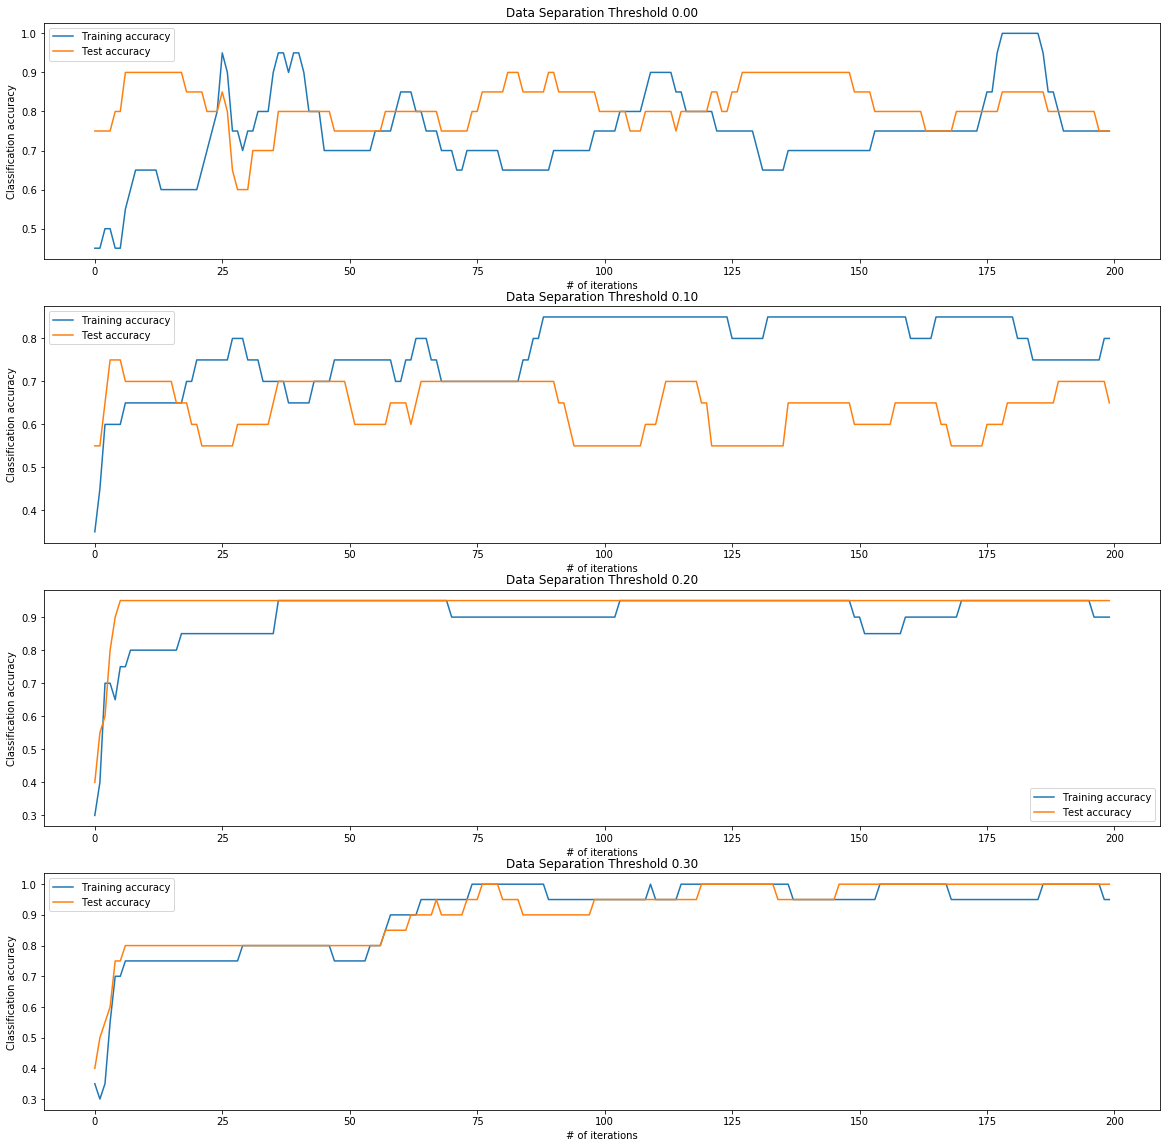

In [18]:
%matplotlib inline

plt.figure(figsize=(20,20)) 

num_thresh = len(thresholds)
for i in range(num_thresh):
    plt.subplot(num_thresh, 1, i + 1)
    plt.plot(thresh_train_accuracies[i], '-', label='Training accuracy')
    plt.plot(thresh_test_accuracies[i], '-', label='Test accuracy')

    plt.title('Data Separation Threshold %0.2f' % thresholds[i])
    plt.xlabel('# of iterations')
    plt.ylabel('Classification accuracy')
    plt.legend(loc='best')

#plt.tight_layout()
plt.show()

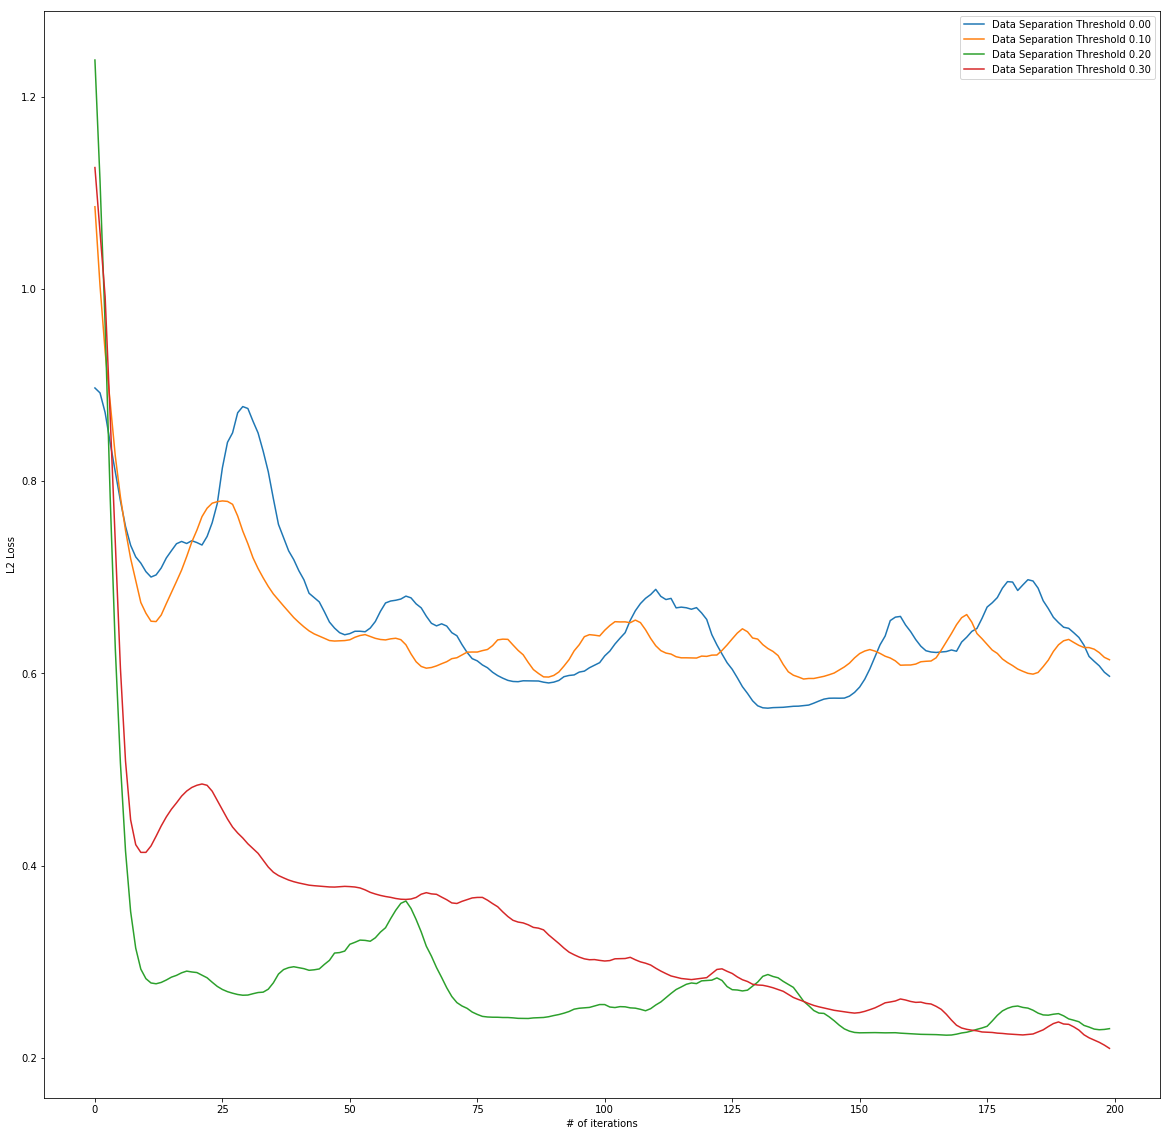

In [19]:
%matplotlib inline

plt.figure(figsize=(20,20)) 

num_thresh = len(thresholds)
for i in range(num_thresh):
    plt.plot(thresh_costs[i], '-', label='Data Separation Threshold %0.2f' % thresholds[i])

plt.xlabel('# of iterations')
plt.ylabel('L2 Loss')
plt.legend(loc='best')

#plt.tight_layout()
plt.show()